# garage 

环境 tpv

https://garage.readthedocs.io/en/latest/user/installation.html#install-garage-in-a-python-environment

In [1]:
#!pip install --user garage

In [2]:
!garage examples

zsh:1: command not found: garage


In [3]:
#https://github.com/rlworkgroup/garage/blob/master/benchmarks/src/garage_benchmarks/experiments/algos/trpo_garage_pytorch.py

!garage examples tf/dqn_cartpole.py > tf_dqn_cartpole.py

zsh:1: command not found: garage


In [4]:
# !python tf_dqn_cartpole.py
!python -m garage.examples.tf.dqn_cartpole.py

/opt/anaconda3/bin/python: Error while finding module specification for 'garage.examples.tf.dqn_cartpole.py' (ModuleNotFoundError: No module named 'garage'). Try using 'garage.examples.tf.dqn_cartpole' instead of 'garage.examples.tf.dqn_cartpole.py' as the module name.


DQN spezifische Metriken (DQN特定指标):
DQN/QFLossMean 8.17667: Q函数（价值函数）的平均损失。这个值本身需要结合训练过程中的变化趋势来看。如果持续下降，说明网络在学习；如果震荡或上升，可能存在学习率过大、目标网络更新频率不当等问题。
DQN/QFLossStd 10.6873: Q函数损失的标准差。这个值比较大，甚至超过了均值，表明损失的波动性较大，可能训练还不够稳定。
策略相关指标：
EpsilonGreedyPolicy/Epsilon 0.02: 当前Epsilon-greedy策略中的Epsilon值。0.02意味着在98%的情况下，智能体会选择当前认为最优的动作（exploitation），而在2%的情况下会随机选择动作（exploration）。
关键点：对于CartPole这种相对简单的环境，如果训练刚开始不久（epoch #3），Epsilon就降到0.02可能太低了。这会导致探索不足，智能体可能过早地收敛到一个次优策略。通常Epsilon会从一个较高的值（如1.0）随训练逐步衰减。


评估指标 (Evaluation Metrics) - 这是判断模型性能的关键：
Evaluation/AverageDiscountedReturn 9.46: 评估期间，100个episode的平均折扣回报。
Evaluation/AverageReturn 9.46: 评估期间，100个episode的平均（未折扣）回报。
核心问题：对于CartPole环境，这个回报值非常低。CartPole-v0通常认为平均回报达到195（持续195步不倒）算解决，CartPole-v1则要求更高（通常是475）。9.46意味着杆子很快就倒了。
Evaluation/Iteration 30: 这可能是评估的迭代次数或评估的ID。
Evaluation/MaxReturn 11: 在100个评估episode中，获得的最大回报是11。
Evaluation/MinReturn 8: 在100个评估episode中，获得的最小回报是8。
解读：最大和最小回报都非常低，且相差不大，说明智能体表现稳定地差。
Evaluation/NumEpisodes 100: 用于评估的episode数量。100是一个不错的样本量，可以提供相对可靠的平均性能。
Evaluation/StdReturn 0.713022: 评估回报的标准差。相对于平均回报9.46来说，这个标准差不算特别大，也印证了表现稳定（但稳定在差的水平）。
Evaluation/TerminationRate 1: 终止率是100%。这意味着在评估的100个episode中，所有episode都因为失败（杆子倒下或车子出界）而终止，而不是因为达到了最大步数限制（如果环境设置了成功时的最大步数）。
环境交互信息：


TotalEnvSteps 20160: 到目前为止，智能体与环境交互的总步数。2万步对于CartPole来说，如果超参数设置合理，通常已经能看到明显的学习效果了。
总结与建议：
当前状态：模型训练处于早期（epoch 3），但从性能指标看，学习效果非常不理想。平均回报9.46远低于CartPole环境的解决标准。


主要问题：
探索不足：Epsilon值在epoch 3就降至0.02，这很可能是导致性能差的主要原因。智能体没有足够的机会探索环境，可能过早地陷入了一个局部最优（而且是很差的局部最优）。
学习不稳定：QFLossStd 较大，可能表明学习过程存在一些不稳定性。
后续行动建议：
检查Epsilon衰减策略：确保Epsilon的初始值较高（如1.0），并且衰减速度不要过快。给智能体更多的时间去探索。可能需要延长衰减的周期，或者使用更平缓的衰减函数。
监控Loss曲线：持续观察QFLossMean和QFLossStd的变化。如果Loss不下降或剧烈震荡，需要调整学习率、目标网络更新频率、Replay Buffer大小等超参数。
检查超参数：
学习率 (Learning Rate)：过大或过小都可能导致问题。
折扣因子 (Discount Factor, Gamma)：对于CartPole，通常设置在0.99左右。
Replay Buffer大小和Batch Size：需要合理配置。
目标网络更新频率 (Target Network Update Frequency)：更新太频繁或太慢都可能影响稳定性。
网络结构：对于CartPole，一个简单的几层全连接网络就足够了。如果网络太复杂，反而可能难以训练。
奖励设计 (Reward Shaping)：虽然CartPole通常不需要复杂的奖励设计（默认每一步奖励+1），但可以确认一下是否被修改过。
环境版本：确认使用的是CartPole-v0还是CartPole-v1，它们的目标分数不同。
总而言之，这份日志显示智能体还没有学会如何在CartPole环境中保持平衡。首要任务是增加探索，并仔细检查和调整DQN算法的各项超参数。

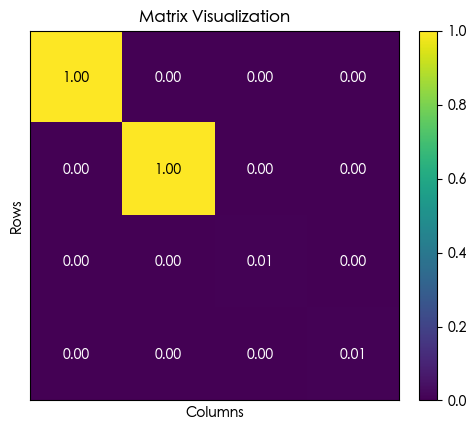

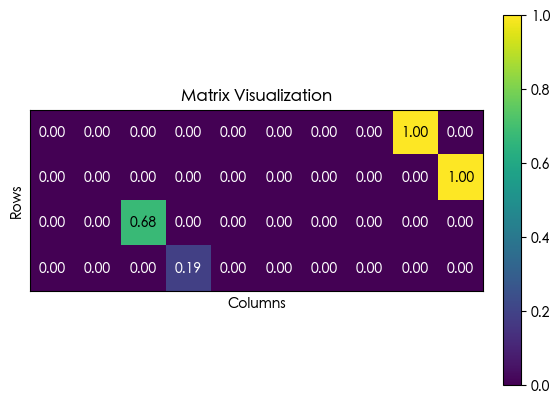

In [5]:
import numpy as np
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Heiti TC']
import matplotlib.pyplot as plt
from scipy.linalg import inv
from control import c2d, dlqr, ss  # 需要安装control库: pip install control

# ==================== 物理参数定义 ====================
# 定义系统物理参数（单位：kg, m, rad等）
m_1 = 0.9      # 车体的质量
m_2 = 0.1      # 摆杆的质量
r = 0.0335     # 车轮的半径
L_1 = 0.126    # 车体的长度
L_2 = 0.390    # 摆杆的长度
l_1 = L_1 / 2  # 车体质心到转轴的距离
l_2 = L_2 / 2  # 摆杆质心到转轴的距离
g = 9.8        # 重力加速度

# 计算转动惯量（刚体绕质心的转动惯量公式）
I_1 = (1/12) * m_1 * L_1**2  # 车体转动惯量
I_2 = (1/12) * m_2 * L_2**2  # 摆杆转动惯量

# ==================== 系统建模 ====================
# 构建惯性矩阵 p (4x4矩阵)
p = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [(r/2)*(m_1*l_1 + m_2*L_1), (r/2)*(m_1*l_1 + m_2*L_1), m_1*l_1**2 + m_2*L_1**2 + I_1, m_2*L_1*l_2],
    [(r/2)*m_2*l_2, (r/2)*m_2*l_2, m_2*L_1*l_2, m_2*l_2**2 + I_2]
])

# 构建重力/外力矩阵 q (4x10矩阵)
q = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, (m_1*l_1 + m_2*L_1)*g, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, m_2*g*l_2, 0, 0, 0, 0, 0, 0]
])
from vis import print_a_matrix
print_a_matrix(p)
print_a_matrix(q)


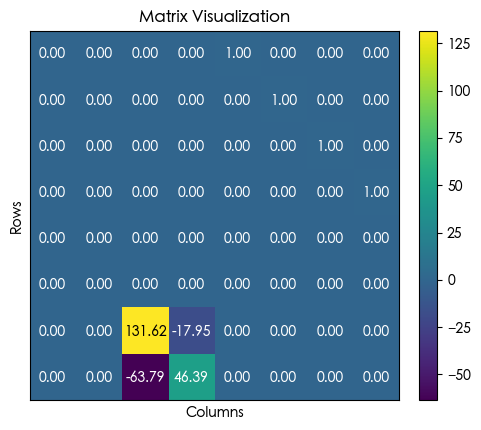

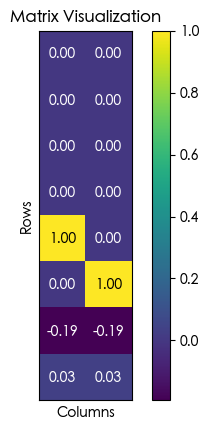

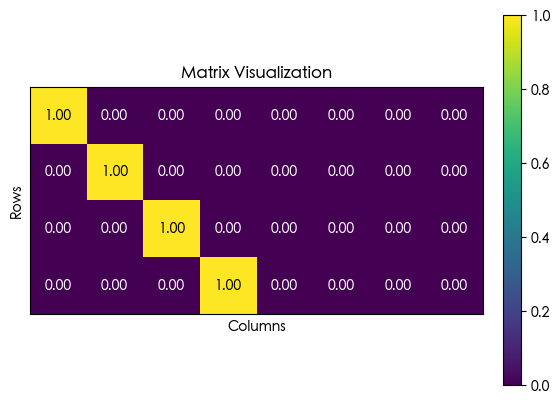

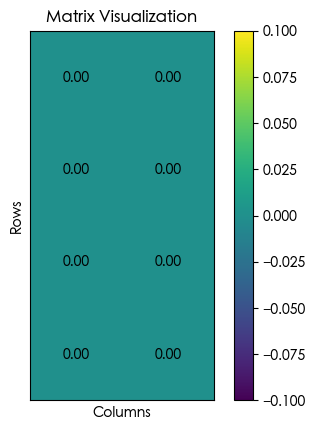

In [6]:

# 计算临时矩阵 (p的逆乘以q)
temp = inv(p) @ q  # Python中使用@表示矩阵乘法

# ==================== 状态空间模型 ====================
# 构建A矩阵 (8x8状态矩阵)
A = np.vstack([
    np.hstack([np.zeros((4,4)), np.eye(4)]),  # 前4行
    temp[:, :8]                                # 后4行
])

# 构建B矩阵 (8x2控制输入矩阵)
B = np.vstack([
    np.zeros((4,2)),  # 前4行
    temp[:, 8:]       # 后4行
])

# 构建C矩阵 (4x8输出矩阵) - 假设观测所有位置状态
C = np.hstack([np.eye(4), np.zeros((4,4))])

# 构建D矩阵 (4x2前馈矩阵) - 通常为零
D = np.zeros((4,2))

print_a_matrix(A)
print_a_matrix(B)
print_a_matrix(C)
print_a_matrix(D)


In [7]:
from env import BalancingCartEnv
env=BalancingCartEnv()
np.allclose(env.A_c, A), np.allclose(env.B_c, B)
#很小的不一样

(False, False)

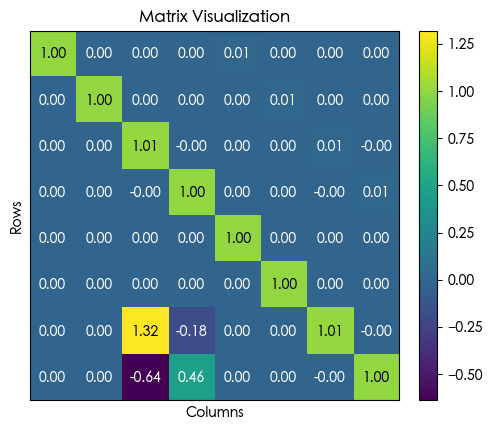

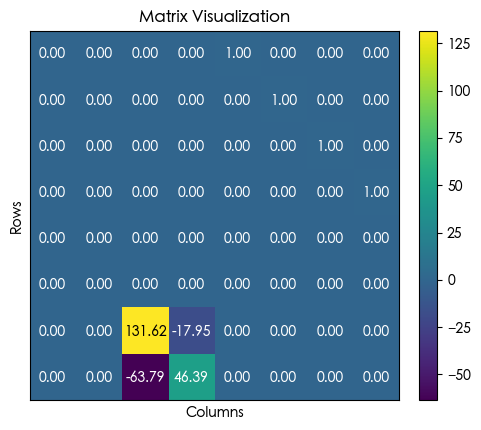

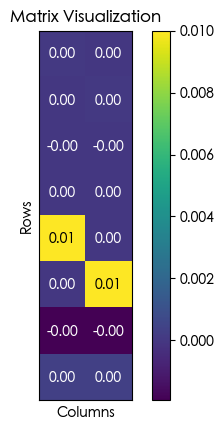

In [8]:

# ==================== LQR控制器设计 ====================
Ts = 0.01  # 采样时间(s)
t = np.arange(0, 7+Ts, Ts)  # 时间向量
u = np.zeros((2, len(t)))    # 零输入信号

# 连续系统离散化
sys_c = ss(A, B, C, D)  # 创建连续状态空间系统
sys_d = c2d(sys_c, Ts, method='zoh')  # 离散化
G, H = sys_d.A, sys_d.B  # 获取离散状态空间矩阵
print_a_matrix(G)
print_a_matrix(A)
print_a_matrix(H)

系统可控！


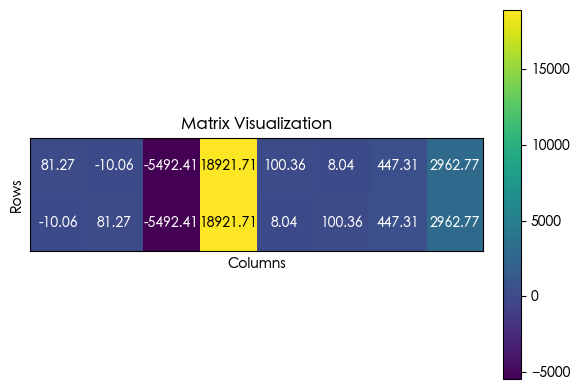

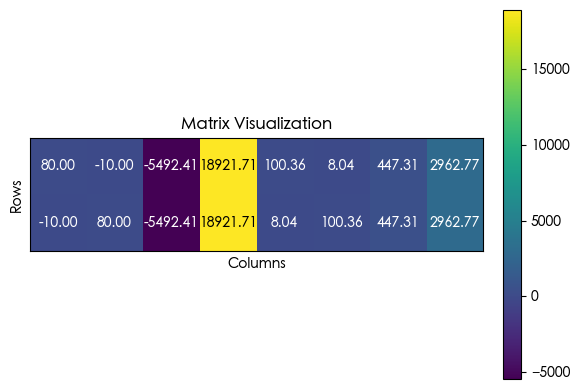

K_1 = [ 8.00000000e+01 -1.00000000e+01 -5.49240612e+03  1.89217098e+04
  1.00363262e+02  8.03757851e+00  4.47308441e+02  2.96277380e+03]
K_2 = [-1.00000000e+01  8.00000000e+01 -5.49240612e+03  1.89217098e+04
  8.03757851e+00  1.00363262e+02  4.47308441e+02  2.96277380e+03]


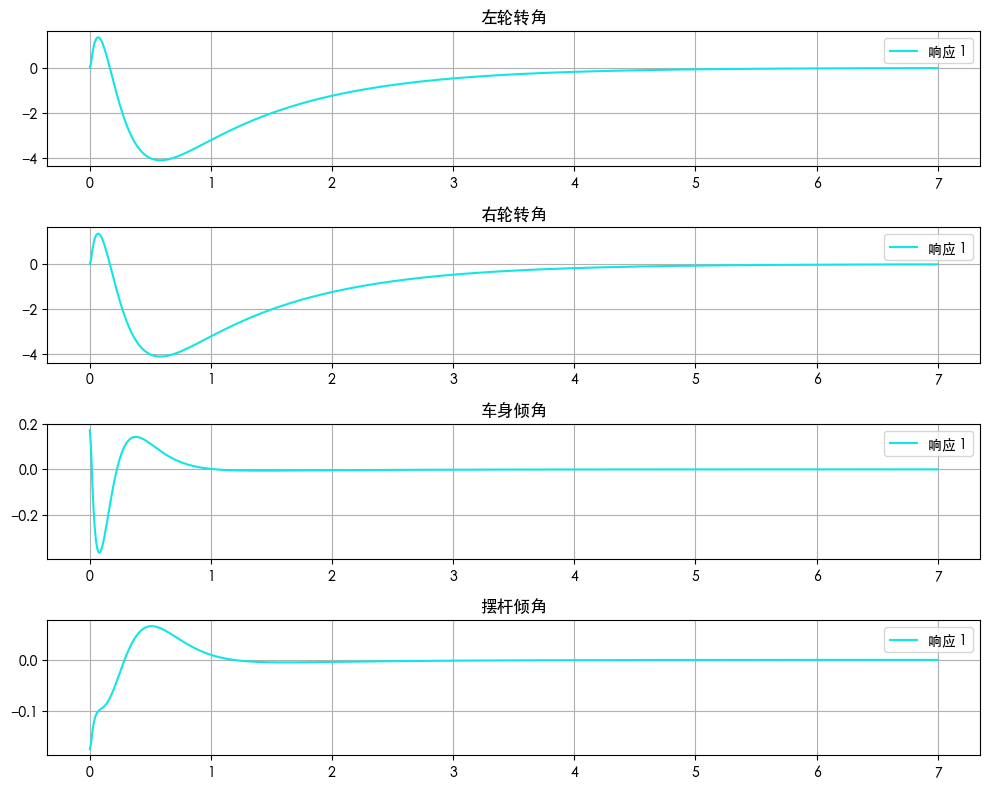

In [9]:

# 初始状态（含小扰动）
x0 = np.array([0, 0, 10/360*2*3.14,-10/360*2*3.14, 0, 0, 0, 0])

# 检查系统可控性
Tc = np.zeros((8,16))  # 可控性矩阵
for i in range(8):
    Tc[:, 2*i:2*(i+1)] = np.linalg.matrix_power(G, i) @ H

from vis import simulate_and_plot,plot_system_outputs

if np.linalg.matrix_rank(Tc) == 8:
    print("系统可控！")
    
    # 定义LQR权重矩阵
    Q = np.diag([51.2938, 51.2938, 32.8281, 131.3123, 
                 51.2938, 51.2938, 131.3123, 131.3123])
    rho = 0.0005
    R = rho * np.eye(2)
    
    # 计算LQR增益矩阵
    K, _, _ = dlqr(G, H, Q, R)
    print_a_matrix(K)
    #K = np.zeros((2,8))  # 2x8的零矩阵替代之前的省略号
    K[:2, :2] = np.array([[80.0, -10.0], [-10.0, 80.0]])  # 对称耦合增益
    print_a_matrix(K)

    # 闭环系统仿真：系统是使用 状态反馈控制律 u_k = -Kx_k 来实现闭环控制的。
    G_cl = G - H @ K  # 闭环状态矩阵
    y = np.zeros((len(t), 4))  # 输出轨迹

        # 打印控制增益
    print("K_1 =", K[0,:])
    print("K_2 =", K[1,:])
    
    # 时域仿真
    simulate_and_plot(x0,t,G_cl,H,u,C)


else:
    print("系统不可控！")

    

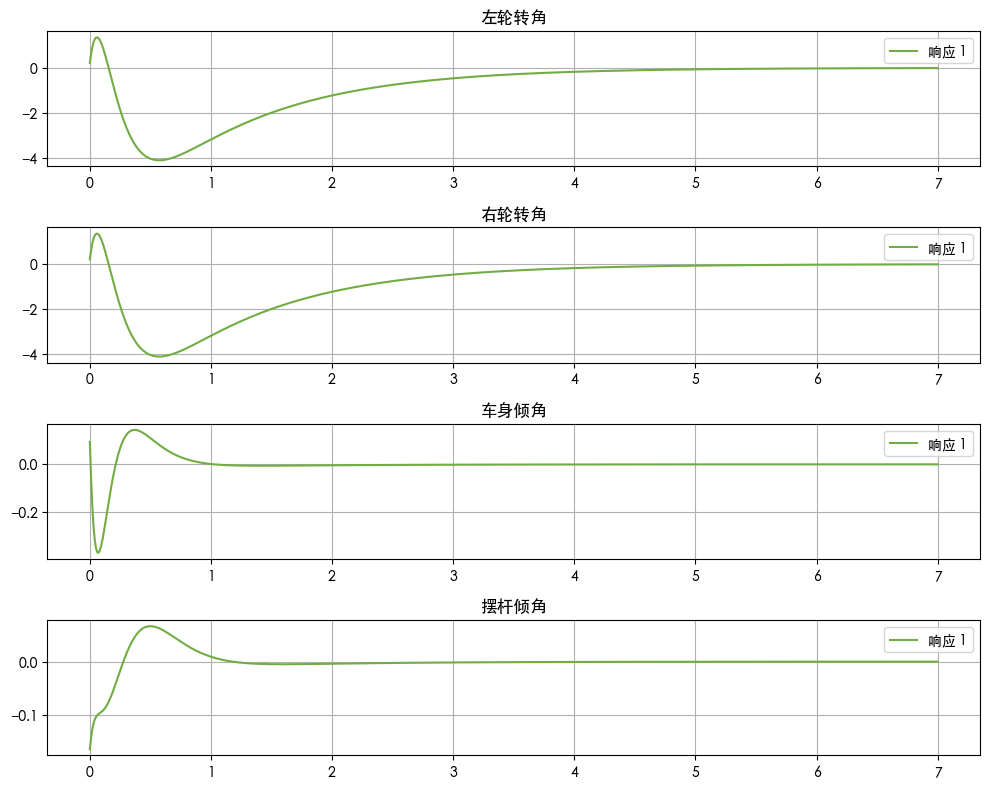

In [10]:
u = np.zeros((2, len(t)))
x = x0.copy()
for i in range(len(t)):
    u[:,i] = -K @ x
    x = G @ x + H @ u[:,i]
    y[i,:] = C @ x
plot_system_outputs(y,t)

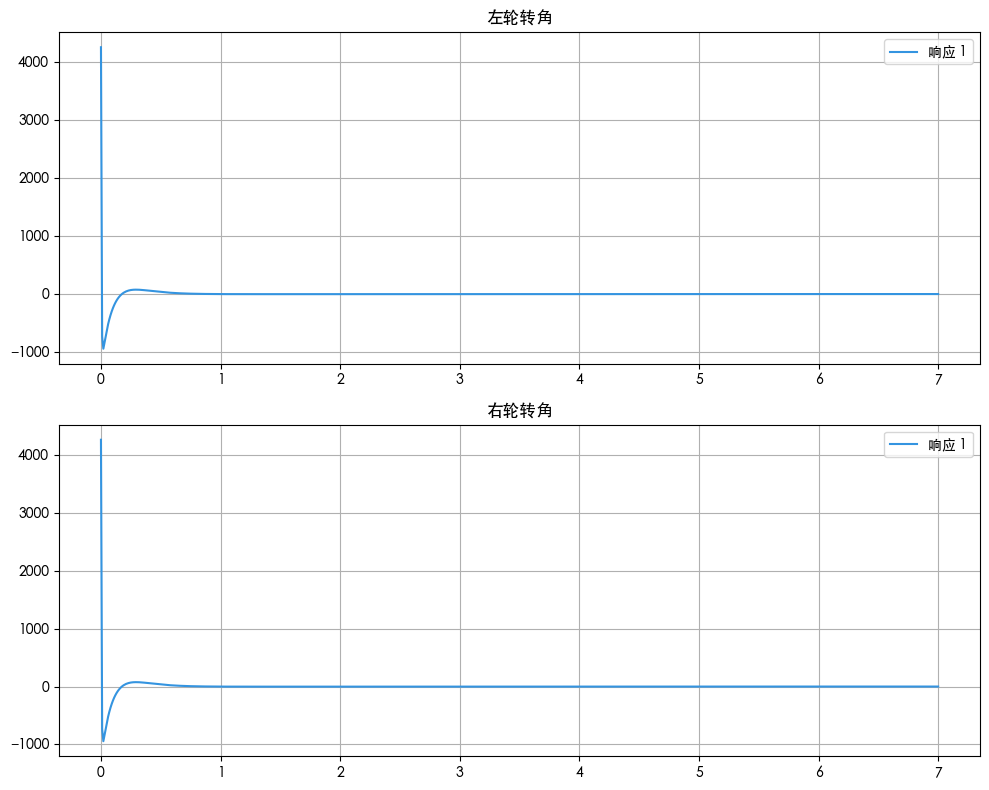

In [11]:
plot_system_outputs(u.T,t)

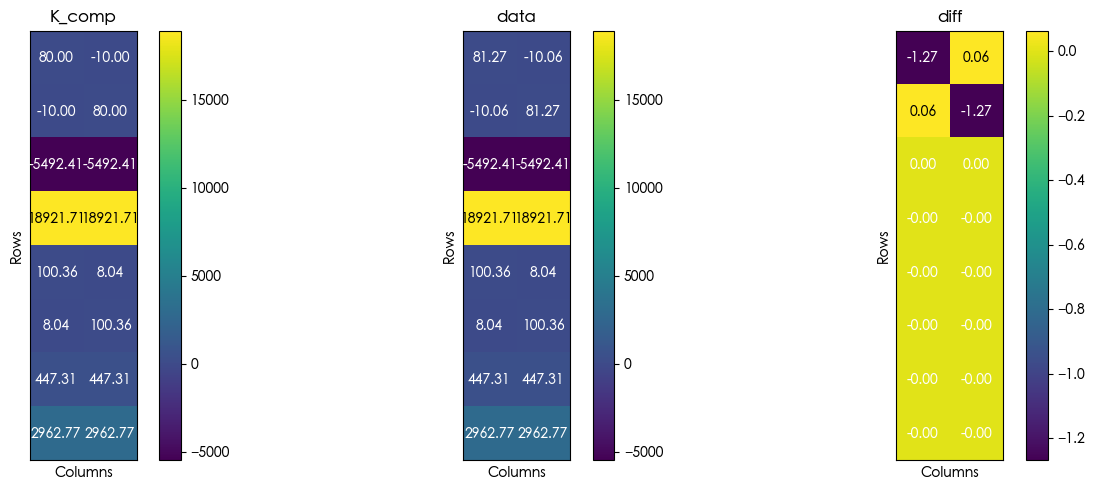

K 与 data 的差异 (K - data):
 [[-1.26945655e+00  6.16418952e-02]
 [ 6.16418951e-02 -1.26945655e+00]
 [ 2.09211066e-08  1.86446414e-08]
 [-6.18769263e-07 -6.21610525e-07]
 [-2.96388691e-09 -3.01596792e-09]
 [-2.96482305e-09 -3.01692182e-09]
 [-2.97534370e-08 -3.01041041e-08]
 [-9.90371518e-08 -9.95228220e-08]]
K 与 data 的最大绝对差值: 1.2694565505289575
K 与 data 的均方根误差(RMSE): 0.4493494821433309
K 与 data 是否近似相等 (allclose): False


In [12]:
import numpy as np

# 假设数据保存在 'K_matrix.txt' 文件中
data = np.loadtxt('K_matrix.txt', delimiter='\t')  # 制表符分隔
data=data.T
from vis import compare_matrices
compare_matrices(K, data)
